In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import json

# make sure we use tensorflow 2.0
import tensorflow as tf
print(tf.__version__)

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

c:\Users\My_Laptop\AppData\Local\conda\conda\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\My_Laptop\AppData\Local\conda\conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\My_Laptop\AppData\Local\conda\conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


2.3.0


In [3]:
current_directory_path = pathlib.Path("./data")
current_directory_path

WindowsPath('data')

In [4]:
# our raw folders
RAW_FOLDER = os.path.join(current_directory_path, "raw")
RAW_FOLDER

'data\\raw'

In [5]:
# checking if GPU is available 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # RIP Training time
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
# checking the total alphabet characters of the whole dataset
raw_data_path = pathlib.Path(RAW_FOLDER)
char_list= set()
dict_file_label={}
for item in raw_data_path.glob('*'):
    label = os.path.basename(os.path.splitext(item)[0])
    dict_file_label[str(item)]=label
    char_list.update(set((label)))
char_list=sorted(char_list)

print("Total number of characters : {}".format(len(char_list)))

Total number of characters : 32


In [7]:
type(char_list)

list

In [8]:
"".join(char_list)

'23456789ABCDEFGHJKLMNPQRSTUVWXYZ'

In [9]:
#find max label length
max_label_len = 0
for i in dict_file_label.values():
    if len(i) > max_label_len: 
        max_label_len = len(i)
max_label_len

4

In [10]:
def encode_to_labels(txt):
    output = []
    for index, chart in enumerate(txt):
        try:
            output.append(char_list.index(chart))
        except:
            print("No found in chart_list: ", chart)
    return output
encode_to_labels("AVCCJ")

[8, 27, 10, 10, 16]

In [11]:
# all possible image paths for training
all_image_paths = list(dict_file_label.keys())
all_image_paths[0:5]

['data\\raw\\222X.png',
 'data\\raw\\226U.png',
 'data\\raw\\2274.png',
 'data\\raw\\22A6.png',
 'data\\raw\\22BJ.png']

In [12]:
min_height, max_height, min_width, max_width = 5000, 0, 5000, 0
for i in all_image_paths:
    img = cv2.imread(i)
    h, w, _ = img.shape
    if h < min_height: min_height = h
    if h > max_height: max_height = h
    if w < min_width: min_width = w
    if w > max_width: max_width = w
(min_height, max_height, min_width, max_width)

(24, 24, 72, 72)

In [13]:
# being a good Data Scientist, we need to have train set and test set
from sklearn.model_selection import train_test_split
test_size = 0.2
train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)

In [14]:
TIME_STEPS = 9 #Out of input CNN

In [15]:
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

i=0
for train_img_path in train_image_paths:
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.
    
    label = dict_file_label[train_img_path]

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 
    i+=1
    if (i%1000 == 0):
        print ("has processed trained {} files".format(i))

has processed trained 1000 files
has processed trained 2000 files
has processed trained 3000 files
has processed trained 4000 files
has processed trained 5000 files
has processed trained 6000 files
has processed trained 7000 files


In [16]:
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for test_img_path in test_image_paths:

    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_file_label[test_img_path]

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed test {} files".format(i))

has processed test 500 files
has processed test 1000 files
has processed test 1500 files


In [17]:
max_label_len = TIME_STEPS
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

In [18]:
# MODEL OF CRNN AND LSTM

# input with shape of height=32 and width=128 
inputs = Input(shape=(24,72,1))
 
# convolution layer with kernel size (3,3)  #(24,72,64)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# pooling layer with kernel size (2,2) to make the height/2 and width/2  #(12,36,64)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

#(12,36,128)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# pooling layer with kernel size (2,2) to make the height/2 and width/2  #(6,18,128)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

#(6,18,256)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

# pooling layer with kernel size (2,2) to make the height/2  #(3,9,256)
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

batch_norm_3 = BatchNormalization()(pool_3)

#(3,9,256)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)

# Batch normalization layer #(3,9,256)
batch_norm_5 = BatchNormalization()(conv_4)

#(3,9,512)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

# pooling layer with kernel size (3,1) to make the height/2 #(1,9,512)
pool_6 = MaxPool2D(pool_size=(3, 1))(batch_norm_6)
 
# # to remove the first dimension of one: (1,9,512) -> (9,512)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_6)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)


act_model = Model(inputs, outputs)

In [19]:
act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 72, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 72, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 36, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 18, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 18, 256)        295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 9, 256)        

In [20]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [21]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath='checkpoint_weights.hdf5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=15,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [22]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 72, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 24, 72, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 12, 36, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 12, 36, 128)  73856       max_pooling2d_4[0][0]            
_______________________________________________________________________________________

In [22]:
# notice I convert everything to numpy array here since model can fit either tensors and numpy array
# the reason why i stick with numpy array because it is simple to code and also because it is baseline solution
# I want to use openCV (can't run with tensors because it is CPU operations)
# And if I want to use tensors then i will make sure my image preprocessing functions uses tensor compatible operations

# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our test data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

In [24]:
# choose batchsize and epochs

batch_size = 32
epochs = 100

history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
                    y=np.zeros(len(training_img)),
                    batch_size=batch_size, 
                    epochs = epochs,
                    validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
                    verbose = 1, callbacks = callbacks_list)

Epoch 1/100
249/249 [==============================] - ETA: 0s - loss: 5.1730
Epoch 00001: val_loss improved from inf to 30.78317, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 20s 78ms/step - loss: 5.1730 - val_loss: 30.7832
Epoch 2/100
248/249 [============================>.] - ETA: 0s - loss: 0.1097
Epoch 00002: val_loss improved from 30.78317 to 6.05378, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 16s 65ms/step - loss: 0.1106 - val_loss: 6.0538
Epoch 3/100
248/249 [============================>.] - ETA: 0s - loss: 0.0939
Epoch 00003: val_loss did not improve from 6.05378
249/249 [==============================] - 15s 61ms/step - loss: 0.0937 - val_loss: 14.1518
Epoch 4/100
248/249 [============================>.] - ETA: 0s - loss: 0.0401
Epoch 00004: val_loss improved from 6.05378 to 0.54067, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 16s 62ms/step - loss: 0.0400 - va

In [25]:
model.save('lastest_model.h5')

#Decode and predict

In [36]:
new_model = act_model
new_model.load_weights('lastest_model.h5')

In [54]:
#predict a image
prediction_single = new_model.predict(valid_img[0:1])
out = K.get_value(K.ctc_decode(prediction_single, input_length=np.ones(prediction_single.shape[0])*prediction_single.shape[1],
                         greedy=True)[0][0])
pred = ""
for p in out[0]:  
        if int(p) != -1:
            pred += char_list[int(p)]
pred

'EYWQ'

In [39]:
step = 20
OFFSET = 0
prediction = new_model.predict(valid_img[OFFSET:step+OFFSET])

In [42]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  EYWQ
predicted text = EYWQ
original_text  =  C7B9
predicted text = C7B9
original_text  =  KKVA
predicted text = KKVA
original_text  =  68CW
predicted text = 68CW
original_text  =  KU98
predicted text = KU98
original_text  =  73EX
predicted text = 73EX
original_text  =  4KDG
predicted text = 4KDG
original_text  =  8TKJ
predicted text = 8TKJ
original_text  =  RKSL
predicted text = RKSL
original_text  =  SLBP
predicted text = SLBP
original_text  =  8D7C
predicted text = 8D7C
original_text  =  C5VM
predicted text = C5VM
original_text  =  PQAM
predicted text = PQAM
original_text  =  JSUT
predicted text = JSUT
original_text  =  3WE5
predicted text = 3WE5
original_text  =  2DLM
predicted text = 2DLM
original_text  =  SCG2
predicted text = SCG2
original_text  =  83AA
predicted text = 83AA
original_text  =  8SYY
predicted text = 8SYY
original_text  =  75Z9
predicted text = 75Z9


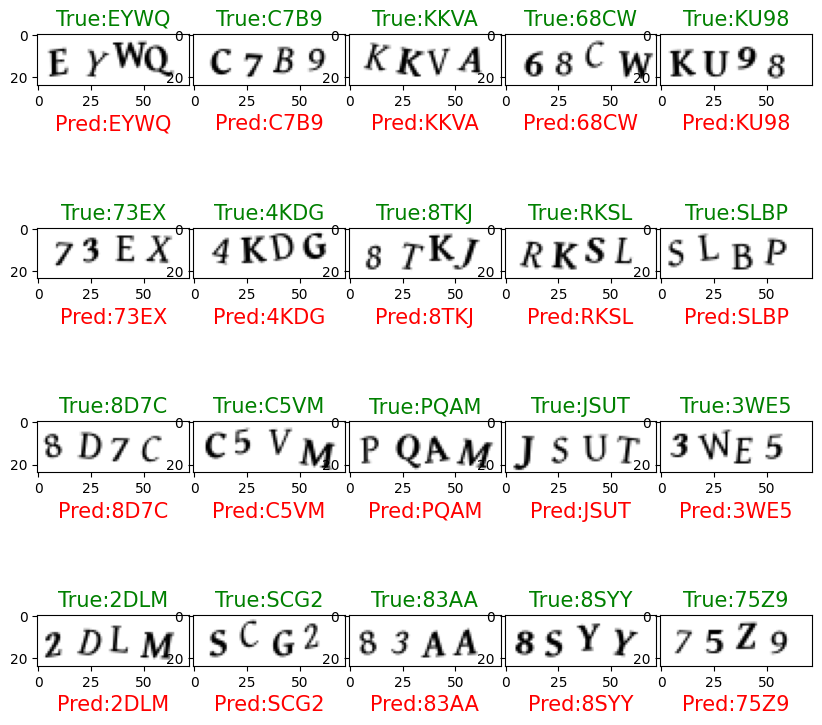

In [43]:
# WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
OFFSET = 0
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,10))
col=0
row=1
gs1 = gridspec.GridSpec(step//5, 5)
gs1.update(wspace=0.025, hspace=0.025)
for n in range(step):
    plt.subplot(gs1[n])
    plt.title("True:"+valid_orig_txt[n+OFFSET], fontsize=15, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel("Pred:"+all_predictions[n+OFFSET], fontsize=15, color="red")